In [62]:
from IPython import display
import IPython.display as ipd
import collections
import datetime
# import fluidsynth
from midi2audio import FluidSynth
import glob
import numpy as np
import pathlib
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pretty_midi
import seaborn as sns
import tensorflow as tf

from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

# Tomb added
import random

In [ ]:
#Download Chorales
data_dir = pathlib.Path('/Volumes/MAGIC1/CS50/myMusicGen/data/chorales')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'midi',
      origin='https://github.com/jamesrobertlloyd/infinite-bach/tree/master/data/chorales/midi',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print(filenames)
print('Number of files:', len(filenames))

In [64]:
class UnsupportedMidiFileException(Exception):
  "Unsupported MIDI File"

In [65]:
"""Tomb made a pretty useful function"""
def check_pianoroll_dim(pianoroll):
        rows = len(pianoroll)  # This gives the number of rows
        columns = len(pianoroll[0])  # This assumes all rows have the same length

        print("Number of rows:", rows) # represents sequence length
        print("Number of columns:", columns) # represents the 4 octave range in midi 36-83
        print("Total dimesions of this pianoroll is", rows*columns)

In [66]:
def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
    pianoroll = midi.get_piano_roll(fs=2*tempo/60) # This is the core line which makes this matrix based on 8th note
    # print(f"piano_roll.shape[1] a.k.a song length!{pianoroll.shape[1]}")

    if pianoroll.shape[1] < seqlen:
        raise UnsupportedMidiFileException

    pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen] # (48, 64) Pinoroll's value still NOT binary since it has velocity
    
    binary_pianoroll = np.heaviside(pianoroll, 0) # converting as a binary matrix
    transposed_pianoroll = np.transpose(binary_pianoroll) #(64, 48)
    # transposed_pianoroll = np.transpose(pianoroll)
    # return binary_pianoroll
    return transposed_pianoroll # type numpy.ndarray

In [67]:
def read_midi(filename, sop_alto, seqlen):
  
  def add_rest_nodes(pianoroll):  # If all the elemets are zero, the rest node says 1, else 0
    rests = 1 - np.sum(pianoroll, axis=1)
    rests = np.expand_dims(rests, 1)
    return np.concatenate([pianoroll, rests], axis=1)
  
  
  # read midi file
  midi = pretty_midi.PrettyMIDI(filename)

  # An Exception error is thrown if there is a modulation(key change)
  if len(midi.key_signature_changes) !=1:
    raise UnsupportedMidiFileException

  # Modulate the given key to C major or C minor
  key_number = midi.key_signature_changes[0].key_number
  # transpose_to_c(midi, key_number)

  # Get Major key(keynode=0) or Minor key(keynode=1)
  keymode = np.array([int(key_number / 12)])

  # The Exception error thrown when tempo changes
  tempo_time, tempo = midi.get_tempo_changes()
  if len(tempo) != 1:
    raise UnsupportedMidiFileException
  if sop_alto:
    # The exception thrown if there are less than 2 parts
    if len(midi.instruments) < 2:
      raise UnsupportedMidiFileException
    # Get pianoRoll returns numpy.ndarray
    pr_s = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0])
    pr_a = get_pianoroll(midi.instruments[1], 36, 84, seqlen, tempo[0])
    pr_b = get_pianoroll(midi.instruments[2], 36, 84, seqlen, tempo[0])
    
    
    sop_w_rest = add_rest_nodes(pr_s) 
    alt_w_rest = add_rest_nodes(pr_a)
    bass_w_rest = add_rest_nodes(pr_b)
    
    # return pr_s, pr_a, pr_b, keymode
    return sop_w_rest, alt_w_rest, bass_w_rest, keymode # All numpy.ndarray including keymode  

  else:
    #Get a pianoroll which gathered all the parts
    pr = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
    return pr, keymode

In [68]:
"""Get the ingredients. 
Make the data(i.e manipulate the model as you tell it what you want) here for predict the 3rd note with given (x1,x2). 
Make list1 that has (xn, xn+1) pair elements 
and list2 which has (xn+2) elements"""

np.set_printoptions(threshold=np.inf) # Show the entire print, esp Matrix

x_all = [] #(1503810, 2) Total dim is  3007620.
y_all = [] # 1503810 Total dim is 1503810
files = [] # Number of files 498 but for collected files, there are 3 files that SKIPPED so we'll only see 495 files. E.g (495, int, int)
# keymodes = [] 

# n_notes = len(x_all) # 1488960. Not sure if it is correct
# print("n_notes!",n_notes)

# repeat the process with all the midi files
for file in glob.glob(str(data_dir/"**/*.mid*")):
  files.append(file)
  try:
    # make a window to get sequence pairs (Xn, Xn+1) -> Xn+2
    sop_data, alt_data, bass_data, keymode = read_midi(file, True, 64)
    sop_data = np.transpose(sop_data) # Transposed because I wanted to access 64 elements to reduce to 62 otherwise 49 becomes 47
    for song in sop_data: # sops_data shape (49, 64)
      for i in range(len(song)-2): # range(0, 62)
        input_sequence = song[i:i+2] # (Xn, Xn +1). print [0. 0.]  shape (2,)
        output_target = song[i+2] # Xn + 2. print 0.0  shape ()
        
        x_all.append(input_sequence)
        y_all.append(output_target)

  # throw exception for midi data which can not be used
  except UnsupportedMidiFileException:
    print("nah")

print("Number of files",len(files))
print(check_pianoroll_dim(x_all))

nah
nah
nah
Number of files 498
Number of rows: 1503810
Number of columns: 2
Total dimesions of this pianoroll is 3007620
None


#### Data preparation
-Convert to np.ndarray<br>
-Extract train and test data<br>
-Reshape(flatten) arrays to send to NNs<br>

In [148]:
input_data = np.array(x_all) # shape (1503810, 2) 1503810 = 495*62*49 <class 'numpy.ndarray'>
output_data = np.array(y_all) # shape (1503810,)  <class 'numpy.ndarray'>

i_train, i_test = train_test_split(range(len(input_data)),test_size=int(len(input_data)/2)) 
# i_train len751905 type<list>: Inside [1229502, 1119523, 845955..// i_test len751905 type<list>: Inside [66058, 610975, 887007..
x_train = input_data[i_train] # <'numpy.ndarray'> shape (751905, 2) [[0. 0.]..  This operation extracts rows from input_data specified by the indices present in i_train.
x_test = input_data[i_test] # <'numpy.ndarray'> shape (751905, 2) [[0. 0.].. For example, if i_train contains [0, 2, 4], input_data[i_train] will extract rows 0, 2, and 4 from input_data.

y_train = output_data[i_train] # shape (751905,) [0. 0. 0. ..
y_test = output_data[i_test] # shape (751905,) [0. 0. 0. ..


# <<<reshape>>>
x_train_reshaped = x_train.reshape(-1,2, 1)  # Reshape to sequences of 2 elements
x_test_reshaped = x_test.reshape(-1, 2, 1)
# Reshape y_train and y_test to match the output shape
y_train_reshaped = y_train.reshape(-1, 1)  # Reshape to target for each sequence
y_test_reshaped = y_test.reshape(-1, 1)

print("x_train",x_train.shape)
print("y_train",y_train.shape)
print("x_train_reshaped",x_train_reshaped.shape)
print("y_train_reshaped",y_train_reshaped.shape)

x_train (751905, 2)
y_train (751905,)
x_train_reshaped (751905, 2, 1)
y_train_reshaped (751905, 1)


In [150]:
# print(check_pianoroll_dim(x_train))
# print(check_pianoroll_dim(y_train))
seq_length = x_train.shape[1] #int 2 # How many sequences for input features
each_step = 1 
# print(pitch_range)
# print(x_train[:10])

In [151]:
# Create an LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64, input_shape=(seq_length, each_step)))  # Input shape corresponds to the reshaped data
model.add(tf.keras.layers.Dense(each_step, activation='sigmoid'))  # Adjust the output units and activation based on your problem

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss and metrics
model.evaluate(x_train, y_train, return_dict=True)


23498/23498 [==============================] - 11s 439us/step - loss: 0.6933 - accuracy: 0.9726


{'loss': 0.6932979822158813, 'accuracy': 0.9725643396377563}

In [152]:
# Train the model

callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath="./training_checkpoints/ckpt_{epoch}",
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )]

epochs = 3
batch_size = 32

history = model.fit(
    x_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    validation_data=(x_test, y_test))

# model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/3
23498/23498 [==============================] - 32s 1ms/step - loss: 0.0612 - accuracy: 0.9839 - val_loss: 0.0580 - val_accuracy: 0.9833
Epoch 2/3
23498/23498 [==============================] - 31s 1ms/step - loss: 0.0582 - accuracy: 0.9844 - val_loss: 0.0575 - val_accuracy: 0.9845
Epoch 3/3
23498/23498 [==============================] - 30s 1ms/step - loss: 0.0580 - accuracy: 0.9844 - val_loss: 0.0577 - val_accuracy: 0.9845


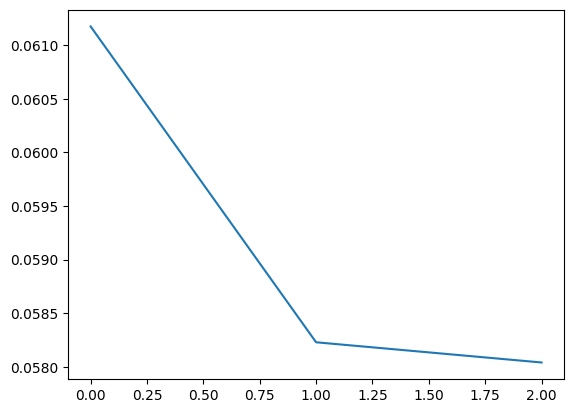

In [153]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
y_pred = model.predict(x_test)
print(y_pred)

In [167]:
_SAMPLING_RATE = 16000
# make a fucntion to be able to do so
def show_and_play_midi(pianorolls, filename):
  def make_midi(pianorolls, filename):
      midi = pretty_midi.PrettyMIDI(resolution=480)
      for pianoroll in pianorolls:
        instr = pretty_midi.Instrument(program=1)
        for i in range(pianoroll.shape[0]):
          for j in range(pianoroll.shape[1]):
              # When the value of each element of the pianoroll binary matrix is ​​greater than 0.5,
              # insert a note of that pitch at that time
              if pianoroll[i][j] > 0.5:
                instr.notes.append(pretty_midi.Note(start=0.50*i,
                                                      end=0.50*(i+1),
                                                      pitch=36+j,
                                                  velocity=100))
        midi.instruments.append(instr)
      midi.write(filename)


  for pr in pianorolls:
    plt.matshow(np.transpose(pr))
    plt.show()

  # Save the midi data into a file, the file name is given in the next cell as output.midi
  make_midi(pianorolls, filename)

  # Convert MIDI to Wav so that you can listen to it on web browser
  fs = FluidSynth(sound_font="/usr/share/sounds/sf2/FluidR3_GM.sf2")
  fs.midi_to_audio("/data/output.mid", "output.wav")

  ipd.display(ipd.Audio(r"data/output.wav", rate=16000))

In [ ]:


k = random.randint(0, len(x_test))

show_and_play_midi(y_pred[k, 0:-1],
"output.mid")

### Unused Code Below>>>

In [197]:
def predict_next_note(
        notes: np.ndarray,
        model: tf.keras.Model,
        temperature: float = 1.0) -> tuple[int]: # -> indicates what you return
    """Generates a note, using a trained sequence model."""
    assert temperature > 0 
    # Add batch dimension
    # inputs = tf.expand_dims(notes, 0)
    predictions = model.predict(notes) # predictions (2,1) 
    # print("predictions",predictions)
    # note_logits = predictions[1]
    note_logits = predictions # should be a 2D tensor for random.categoriacal's 1st arg by accessing the [1]. note_logits (64, 49)
    # print(note_logits.shape)
    note_logits /= temperature
    # print("note_logits", note_logits.shape)
    pitch = tf.random.categorical(note_logits, num_samples=1) #random.categorical requires 2D tensor for logits
    # print("categorical pitch",pitch)
    pitch = tf.squeeze(pitch, axis=-1)
    # print(f"pitch after squeezed{pitch}")
    
    print("pitch",pitch)
    return pitch # shape (64,)

In [ ]:
temperature = 2.0
# input_notes = x_test[:seq_length]
input_notes = x_test # shape (751905, 2)
# print(y_test.shape)

generated_notes = predict_next_note(input_notes, model, temperature)

generated_notes = pd.DataFrame(
    generated_notes
)
generated_notes.columns = ["pitch"] # Give the label to the column to access it
generated_notes.head(10) # Using slice due to the huge data
print(generated_notes[:1])

In [193]:
_SAMPLING_RATE = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=40):
    waveform = pm.fluidsynth(fs=float(_SAMPLING_RATE))
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE) # this display class is from IPython

In [194]:
def pandas_to_midi(notes:pd.DataFrame):
    data = notes["pitch"]
    df = pd.DataFrame(data)

    # Convert pitch values to MIDI notes
    notes = df['pitch'].tolist()
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    # Add notes to the MIDI object
    for i, note in enumerate(notes):
        note_start = i * 0.5  # Adjust the start time as needed
        note_end = note_start + 0.4  # Adjust the end time as needed. Make + 1.4 you can hear pedal-sustain like notes
        midi_note = pretty_midi.Note(velocity=100, pitch=note, start=note_start, end=note_end)
        instrument.notes.append(midi_note)

    pm.instruments.append(instrument)
    
    return pm

In [ ]:
pm = pandas_to_midi(generated_notes)

# Display audio using your function
display_audio(pm)


In [ ]:
"""faled model"""
# # Assuming the shapes you've provided: x_train, x_test, y_train, y_test

# # Create an LSTM model
# model = tf.keras.Sequential()

# # Add an LSTM layer
# model.add(tf.keras.layers.LSTM(units=64, input_shape=(2, 1)))  # LSTM units can be adjusted based on the complexity of the problem

# # Add a dense layer for output
# model.add(tf.keras.layers.Dense(1, activation='softmax'))  # Adjust the output shape based on your targets

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.evaluate(x_train, y_train, return_dict=True)

# # Train the model
# model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))



'faled model'

In [ ]:
# seq_length = x_train.shape[1] # 2 -> 時系列の長さ(時間方向の要素数)
# input_dim = x_train.shape[2] # 64 -> 入力の各要素の次元数
# output_dim = y_train.shape[2] # 47-> 出力の各要素の次元数

In [ ]:
# """get inputs (Xn, Xn+1) and target (Xn+2) """
# def make_sequences(
#         dataset: tf.data.Dataset,
#         seq_length:int,
# ) -> tf.data.Dataset:
    
#     seq_length = seq_length+1

#     windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)
#     # for w in windows:
#     #    print(f"window!! {list(w.as_numpy_iterator())}")
    
#     flatten = lambda x: x.batch(seq_length, drop_remainder=True) # Assing lambda function to the variable "flatten"
#     sequences = windows.flat_map(flatten) # Flat_map falltens the "dataset of datasets" into a dataset of tensors

#     def split_labels(sequences):
#         inputs = sequences[:-1] # Could not see the inside as this func got in through map_func
#         output_dense = sequences[-1]
#         return inputs, output_dense
    
#     return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# sop_tf_data = [] #  A list which contains (64 ,49) tf.daset elements
# sop, alt, bass, keymode = read_midi(f, True, 64)
# # sop = sop[0]
# # sop_tf = tf.data.Dataset.from_tensor_slices(sop)
# # print(list(sop_tf.as_numpy_iterator()))

# for i in sop:
#     sop_tf = tf.data.Dataset.from_tensor_slices(i)
#     sop_tf_data.append(sop_tf)

# # for t in sop_tf_data:
#     # print(list(t.as_numpy_iterator()))


In [ ]:
# single_sop_tf = sop_tf_data[0]
# seq_length = 2
# # print(make_sequences(single_sop_tf, seq_length))

# seq_ds = make_sequences(single_sop_tf, seq_length) # 47 elements each input n output
# # type <'tensorflow _ParallelMapDataset'>
# # print(seq_ds.element_spec)
# # print(list(seq_ds.as_numpy_iterator())) # [(array([0., 0.]), 0.0), (array([0., 0.]), 0.0)...


# inputList = []
# targetList = []

# #<Check the dataset elements>
# for seq, target in seq_ds:
#   # print('Input sequence shape:', seq.shape) # shape (2,), a one-dimensional array (vector) with a length of 2.
#   # print('Input sequence elements:', seq[0: 1]) 
#   # print('target:', target) # shape ()
#   # print()
#   inputList.append(seq) # <class 'list'>
#   targetList.append(target) # <class 'list'>

# inputList = np.array(inputList) # <class 'numpy.ndarray'>. shape (47, 2), 2D matrix
# targetList = np.array(targetList) # <class 'numpy.ndarray'> shape (47,), 1D scalar